In [1]:
import sys,os,os.path
sys.path.append("/gluster/data/next/software/IC_satkill/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_satkill/'


import traceback

import os
import sys
import random
from tqdm import tqdm
import tables as tb
import numpy  as np
import pandas as pd
import scipy.spatial.distance as scidist
import invisible_cities.core.fit_functions  as fitf
from   invisible_cities.core.stat_functions import poisson_sigma
import invisible_cities.reco.dst_functions  as dstf
from   invisible_cities.core.core_functions import shift_to_bin_centers
from invisible_cities.core.testing_utils import assert_hit_equality
from IC.invisible_cities.reco.paolina_functions import voxelize_hits, drop_end_point_voxels, make_track_graphs, get_track_energy
# hack to avoid QhullError
from scipy.spatial.qhull import QhullError
from scipy import spatial
spatial.QhullError = QhullError
#from  skimage.morphology import skeletonize_3d

from invisible_cities.evm                  import event_model as evm
from invisible_cities.evm  .event_model    import Cluster, Hit
from invisible_cities.types.ic_types       import xy
from invisible_cities.reco import paolina_functions    as plf

from invisible_cities.io.dst_io import load_dst
import invisible_cities.io.mcinfo_io as mcio

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.patheffects as PathEffects
import matplotlib.lines as mlines


#import core.functions as func

import imageio

In [11]:


path = '/gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/BEERSHEBA_STUDY/e_cut/rel_0.2_new/'
folder_paths = [path + 'PORT_1a/beersheba/']

# load one file
data = pd.read_hdf(folder_paths[0] + 'beersheba_2_208Tl.h5', 'DECO/Events')
print(data.event.unique())

[20000 20002 20004 20006 20008 20010 20012 20014 20016 20018 20020 20022
 20024 20026 20028 20030 20032 20034 20036 20038 20040 20042 20044 20046
 20048 20050 20052 20054 20056 20058 20060 20062 20064 20066 20068 20070
 20072 20074 20076 20078 20080 20082 20084 20086 20088 20090 20092 20094
 20096 20098 20100 20102 20104 20106 20108 20110 20112 20114 20116 20118
 20120 20122 20124 20126 20128 20130 20132 20134 20136 20138 20140 20142
 20144 20146 20148 20150 20152 20154 20156 20158 20160 20162 20164 20166
 20168 20170 20172 20174 20176 20178 20180 20182 20184 20186 20188 20190
 20192 20194 20196 20198 20200 20202 20204 20206 20208 20210 20212 20214
 20216 20218 20220 20222 20224 20226 20228 20230 20232 20234 20236 20238
 20240 20242 20244 20246 20248 20250 20252 20254 20256 20258 20260 20262
 20264 20266 20268 20270 20272 20274 20276 20278 20280 20282 20284 20288
 20290 20292 20294 20296 20298 20300 20302 20304 20306 20308 20312 20314
 20316 20318 20320 20322 20324 20326 20328 20330 20

In [5]:
evt = 20030

## MC
true_info = mcio.load_mchits_df(folder_paths[0] + 'beersheba_2_208Tl.h5').reset_index()

this_evt_true_info = true_info[true_info.event_id == evt // 2]

xt = this_evt_true_info.x
yt = this_evt_true_info.y
zt = this_evt_true_info.z

## DATA
bad_evt = data[data.event == evt]

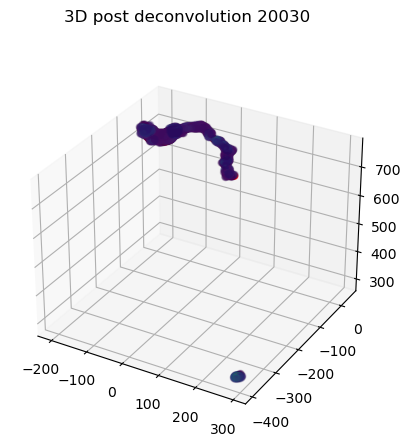

In [6]:
x = bad_evt.X
y = bad_evt.Y
z = bad_evt.Z
e = bad_evt.E

fig = plt.figure()
fig.suptitle('3D post deconvolution ' + str(evt), fontsize=12)
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(x, y, z, c=e, alpha=0.03, cmap='viridis')
q = ax.scatter(xt, yt, zt, alpha = 0.3, color = 'r')

In [10]:
particle = pd.read_hdf(folder_paths[0] + 'beersheba_2_208Tl.h5', 'MC/particles')
print(particle.event_id.unique())

[10000 10001 10002 10003 10004 10005 10006 10007 10008 10009 10010 10011
 10012 10013 10014 10015 10016 10017 10018 10019 10020 10021 10022 10023
 10024 10025 10026 10027 10028 10029 10030 10031 10032 10033 10034 10035
 10036 10037 10038 10039 10040 10041 10042 10043 10044 10045 10046 10047
 10048 10049 10050 10051 10052 10053 10054 10055 10056 10057 10058 10059
 10060 10061 10062 10063 10064 10065 10066 10067 10068 10069 10070 10071
 10072 10073 10074 10075 10076 10077 10078 10079 10080 10081 10082 10083
 10084 10085 10086 10087 10088 10089 10090 10091 10092 10093 10094 10095
 10096 10097 10098 10099 10100 10101 10102 10103 10104 10105 10106 10107
 10108 10109 10110 10111 10112 10113 10114 10115 10116 10117 10118 10119
 10120 10121 10122 10123 10124 10125 10126 10127 10128 10129 10130 10131
 10132 10133 10134 10135 10136 10137 10138 10139 10140 10141 10142 10144
 10145 10146 10147 10148 10149 10150 10151 10152 10153 10154 10156 10157
 10158 10159 10160 10161 10162 10163 10164 10165 10

In [12]:
particle_evt = particle[particle.event_id == 20030//2]
display(particle_evt)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
1376,10015,1,Tl208,True,0,396.378479,394.808136,536.859741,0.000000,396.378479,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,none,RadioactiveDecay
1377,10015,4,e-,False,1,396.378479,394.808136,536.859741,0.000725,395.573456,...,-0.367623,-0.314352,0.552248,0.000000,-0.000000,0.0000,0.383463,1.709509,RadioactiveDecay,eIoni
1378,10015,3,anti_nu_e,False,1,396.378479,394.808136,536.859741,0.000725,12500.000000,...,1.102344,-0.206309,-0.206500,1.102344,-0.206309,-0.2065,1.140337,12520.778320,RadioactiveDecay,Transportation
1379,10015,2,Pb208[3475.078],False,1,396.378479,394.808136,536.859741,0.000725,396.378479,...,-0.734722,0.520661,-0.345748,-0.000000,0.000000,-0.0000,0.000002,0.000000,RadioactiveDecay,RadioactiveDecay
1380,10015,6,gamma,False,2,396.378479,394.808136,536.859741,0.000725,402.326996,...,0.101960,-0.141872,-0.215427,-0.000000,0.000000,0.0000,0.277367,18.571981,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,10015,88,e-,False,60,4.123047,2.328282,660.418274,2.043737,4.123086,...,0.003593,-0.000351,-0.005817,0.000000,-0.000000,-0.0000,0.000046,0.000075,phot,msc
1461,10015,87,e-,False,60,4.123047,2.328282,660.418274,2.043737,4.123117,...,0.002155,0.023375,-0.001773,0.000000,0.000000,-0.0000,0.000542,0.002914,phot,eIoni
1462,10015,86,e-,False,60,4.123047,2.328282,660.418274,2.043737,4.120927,...,-0.037275,0.001291,0.012494,0.000000,-0.000000,0.0000,0.001512,0.012379,phot,eIoni
1463,10015,59,e-,False,31,4.232697,1.421704,655.394104,2.025956,4.088283,...,-0.121311,-0.079837,0.021798,0.000000,-0.000000,-0.0000,0.020683,0.849078,eIoni,eIoni
